### **Objetivo del Proyecto:** **Modelos Polinomiales y Regularizados**

El objetivo de este proyecto es abordar el ciclo de Machine Learning para construir y evaluar modelos de aprendizaje automático que permitan predecir la demanda de bicicletas eléctricas durante las diferentes estaciones del año. Además, se busca identificar los factores más influyentes en la decisión de los usuarios al rentar una bicicleta eléctrica, proporcionando insights valiosos para mejorar el sistema de alquiler y promover la movilidad sostenible.

#### **Importación de Librerías**

In [76]:
# librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#### **Carga y Exploración Inicial de los Datos**


Procedemos a cargar los datos desde el archivo ubicado en el directorio del proyecto. Una vez cargados los datos en un DataFrame de pandas, utilizamos el método .head() para inspeccionar las primeras cinco observaciones y así obtener una visión preliminar de la estructura y el contenido del dataset.

In [3]:
df = pd.read_excel("Datos_Etapa-1.xlsx")

df.head()

,"season,weekday,weathersit,temp,atemp,hum,windspeed,cnt,time_of_day"
0,"Winter,6,Clear,3.2799999999999994,3.0014000000..."
1,"Winter,6,Clear,2.34,1.9982000000000006,0.8,0.0..."
2,"Winter,6,Clear,2.34,1.9982000000000006,0.8,0.0..."
3,"Winter,6,Clear,3.2799999999999994,3.0014000000..."
4,"Winter,6,Clear,3.2799999999999994,3.0014000000..."


#### **Limpieza Inicial de Datos**

Tras convertir el archivo de Excel a formato CSV, se identificó una inconsistencia en los datos debido a la presencia de comillas en cada línea del archivo. Este problema obstaculizaba la correcta lectura del archivo. Para resolver esto, realizamos una limpieza directa en el archivo CSV utilizando el método replace() de Python. Primero, abrimos el archivo con with open, luego leemos y sobrescribimos el contenido para eliminar las comillas. Posteriormente, recargamos el archivo en formatos CSV y Excel, confirmando que ahora se abre correctamente y cargamos los datos en un DataFrame para iniciar el proceso de exploración.

In [4]:
# se convierte el archivo a csv
df.to_csv("Datos_Etapa-1.csv", index=False)

# se eliminan las comillas que estan produciendo el error al leer el archivo
with open("Datos_Etapa-1.csv", "r") as file:
    lines = file.readlines()


with open("Datos_Etapa-1.csv", "w") as file:
    for line in lines:
        file.write(line.replace('"', ''))

# ahora se lee el nuevo archivo de csv sin ""
data_raw = pd.read_csv("Datos_Etapa-1.csv")

data_raw.to_excel("Datos_Etapa-1.xlsx")
data_raw.head()

,season,weekday,weathersit,temp,atemp,hum,windspeed,cnt,time_of_day
0,Winter,6,Clear,3.28,3.0014,0.81,0.0,16,Night
1,Winter,6,Clear,2.34,1.9982,0.80,0.0,40,Night
2,Winter,6,Clear,2.34,1.9982,0.80,0.0,32,Night
3,Winter,6,Clear,3.28,3.0014,0.75,0.0,13,Night
4,Winter,6,Clear,3.28,3.0014,0.75,0.0,1,Night


#### **Exploración y Perfilamiento de Datos**


El siguiente paso en nuestro ciclo de Machine Learning es la exploración y perfilamiento de Datos. Esta etapa es crucial para asegurar la calidad del dataset, permitiendo identificar y corregir problemas antes de aplicar técnicas de modelado. Para esto, se utilizarán las siguientes técnicas:

 - Revisión de duplicados: identificación y eliminación de registros duplicados que puedan sesgar los resultados.
 - Análisis de datos nulos: detección de valores faltantes y decisiones sobre su imputación o eliminación.
 - Distribuciones de variables: visualización y análisis de la distribución de las variables, incluyendo la variable objetivo, para detectar sesgos y outliers.
 - Mapas de correlación: evaluación de la relación entre las variables para identificar multicolinealidades y decidir sobre posibles reducciones dimensionales.

In [6]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       17379 non-null  object 
 1   weekday      17379 non-null  int64  
 2   weathersit   17379 non-null  object 
 3   temp         17379 non-null  float64
 4   atemp        17379 non-null  float64
 5   hum          17379 non-null  float64
 6   windspeed    17379 non-null  float64
 7   cnt          17379 non-null  int64  
 8   time_of_day  17379 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 1.2+ MB


In [8]:
data_raw.isna().sum()

season         0
weekday        0
weathersit     0
temp           0
atemp          0
hum            0
windspeed      0
cnt            0
time_of_day    0
dtype: int64

In [11]:
dup = data_raw.duplicated().sum()

print(dup)

42


In [14]:
duplicate_columns = [column for column in data_raw.columns if data_raw[column].duplicated().any()]

duplicate_columns

['season',
 'weekday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'cnt',
 'time_of_day']

In [15]:
data_raw.describe()

,weekday,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,3.003683,15.358397,15.401157,0.627229,12.736540,189.463088
std,2.005771,9.050138,11.342114,0.192930,8.196795,181.387599
min,0.000000,-7.060000,-16.000000,0.000000,0.000000,1.000000
25%,1.000000,7.980000,5.997800,0.480000,7.001500,40.000000
50%,3.000000,15.500000,15.996800,0.630000,12.998000,142.000000
75%,5.000000,23.020000,24.999200,0.780000,16.997900,281.000000
max,6.000000,39.000000,50.000000,1.000000,56.996900,977.000000


In [17]:
for col in data_raw.select_dtypes(include=['object']).columns:
    print(f"\nValores únicos en {col}:")
    print(data_raw[col].value_counts())


Valores únicos en season:
season
Summer    4496
Spring    4409
Winter    4242
Fall      4232
Name: count, dtype: int64

Valores únicos en weathersit:
weathersit
Clear         11413
Mist           4544
Light Rain     1419
Heavy Rain        3
Name: count, dtype: int64

Valores únicos en time_of_day:
time_of_day
Night      6471
Morning    5805
Evening    5103
Name: count, dtype: int64


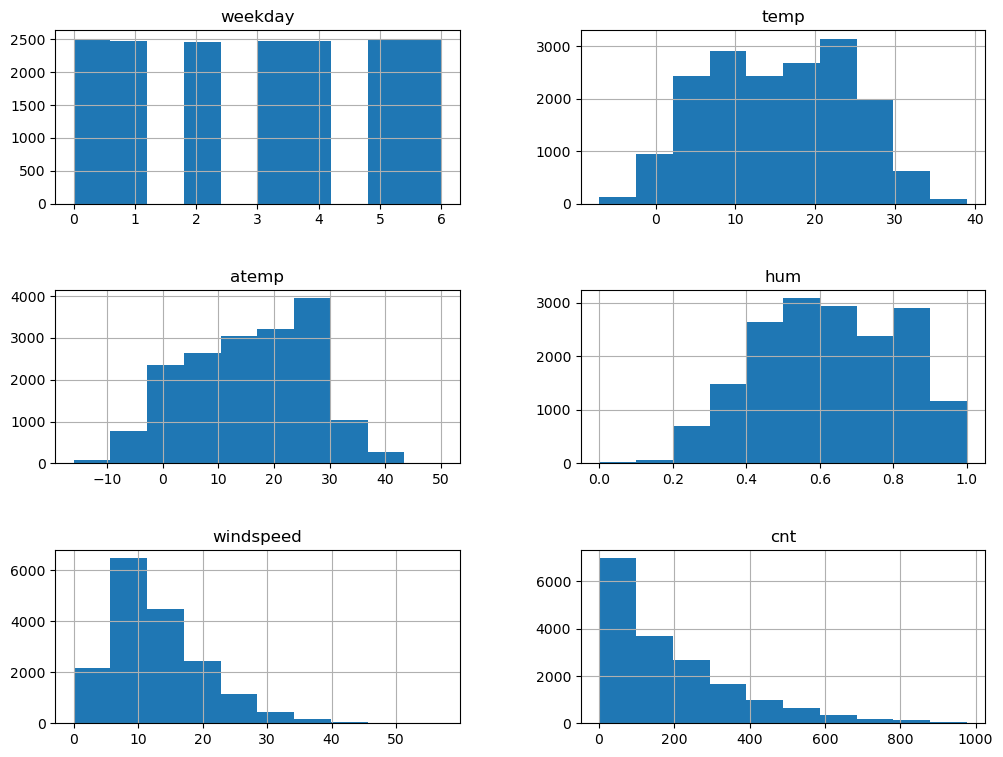

In [18]:
# visualizaciones de la distribucion de variables numericas
numerical_columns = [i for i in data_raw.columns if data_raw[i].dtypes != 'object']
numerical_columns = data_raw[numerical_columns]
numerical_columns.hist(figsize=(12,9))
plt.subplots_adjust(hspace=0.5);

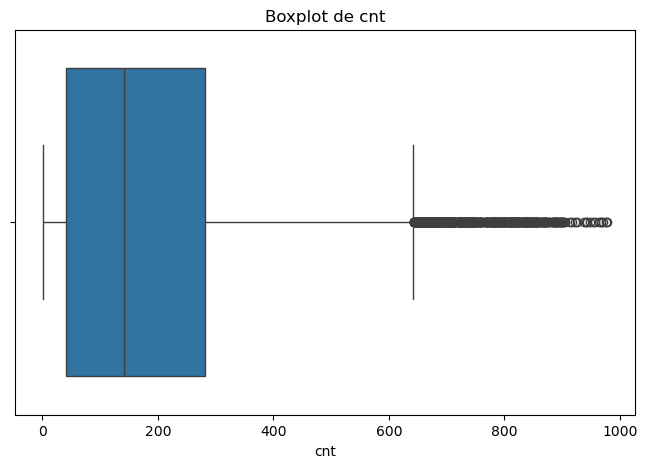

In [27]:
# explorando la distribucion de la variable objetivo
plt.figure(figsize=(8, 5))
sns.boxplot(x=data_raw["cnt"])
plt.title("Boxplot de cnt")
plt.show()

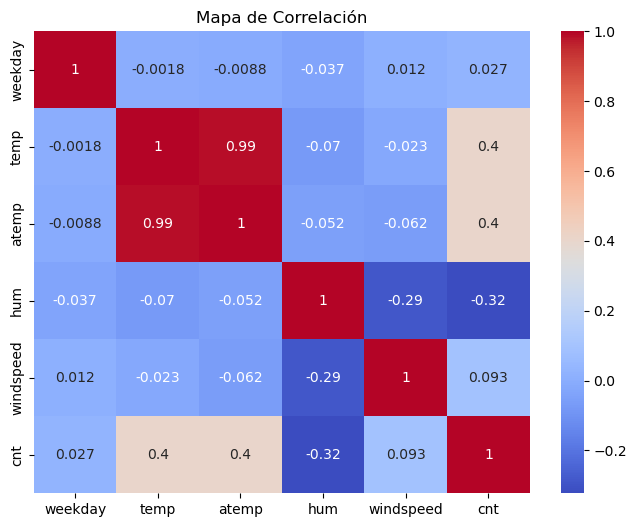

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(numerical_columns.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Correlación')
plt.show()

In [67]:
# identificando los valores duplicados para tomar la decision de eliminarlos del dataset
duplicates = data_raw[data_raw.duplicated()]


duplicates

,season,weekday,weathersit,temp,atemp,hum,windspeed,cnt,time_of_day
106,Winter,3,Clear,6.10,3.0014,0.28,12.9980,62,Evening
435,Winter,4,Clear,4.22,1.0016,0.56,11.0014,1,Night
647,Winter,0,Clear,-1.42,-2.0014,0.86,0.0000,3,Morning
691,Winter,2,Mist,-0.48,-0.9982,0.69,0.0000,2,Night
761,Winter,5,Mist,-1.42,-4.9978,0.63,7.0015,1,Night
811,Winter,0,Clear,4.22,1.0016,0.60,15.0013,1,Morning
1645,Winter,1,Clear,4.22,3.0014,0.65,6.0032,1,Night
1881,Spring,4,Mist,5.16,1.9982,1.00,12.9980,1,Night
1998,Spring,2,Clear,3.28,-2.0014,0.32,19.9995,3,Night
2045,Spring,4,Light Rain,3.28,-0.9982,0.93,12.9980,5,Night


#### **Preparación de datos**

Durante el perfilamiento, se descubrieron 42 valores duplicados. Aunque estos registros mostraban diferentes valores en la variable objetivo, se decidió eliminarlos debido a su baja representación en el dataset (42 de más de 17,000 observaciones). Además, no se encontraron valores nulos en las variables. Las visualizaciones revelaron una distribución ligeramente sesgada en la variable objetivo, con la presencia de algunos outliers. Se observó una alta correlación entre las variables "temp" y "atemp", lo que llevó a la decisión de eliminar atemp para evitar problemas de multicolinealidad y sobreajuste en los modelos de regresión. Finalmente, se realizó la división de los datos en variables predictoras (X) y la variable objetivo (y), preparándonos así para la etapa de preprocesamiento y modelado.

In [89]:
df1 = data_raw.copy()
df1.head()

,season,weekday,weathersit,temp,atemp,hum,windspeed,cnt,time_of_day
0,Winter,6,Clear,3.28,3.0014,0.81,0.0,16,Night
1,Winter,6,Clear,2.34,1.9982,0.80,0.0,40,Night
2,Winter,6,Clear,2.34,1.9982,0.80,0.0,32,Night
3,Winter,6,Clear,3.28,3.0014,0.75,0.0,13,Night
4,Winter,6,Clear,3.28,3.0014,0.75,0.0,1,Night


In [90]:
df1 = df1.drop(['atemp'], axis=1)

df1.head()

,season,weekday,weathersit,temp,hum,windspeed,cnt,time_of_day
0,Winter,6,Clear,3.28,0.81,0.0,16,Night
1,Winter,6,Clear,2.34,0.80,0.0,40,Night
2,Winter,6,Clear,2.34,0.80,0.0,32,Night
3,Winter,6,Clear,3.28,0.75,0.0,13,Night
4,Winter,6,Clear,3.28,0.75,0.0,1,Night


In [91]:
# eliminamos los duplicados 
df1 = df1.drop_duplicates()

df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17337 entries, 0 to 17378
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       17337 non-null  object 
 1   weekday      17337 non-null  int64  
 2   weathersit   17337 non-null  object 
 3   temp         17337 non-null  float64
 4   hum          17337 non-null  float64
 5   windspeed    17337 non-null  float64
 6   cnt          17337 non-null  int64  
 7   time_of_day  17337 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 1.2+ MB


In [69]:
# aplicando train_test_split
X = df1.drop(['cnt'], axis=1)
y = df1['cnt']

print(X.shape, y.shape)

(17337, 7) (17337,)


In [70]:
# aplicando train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

In [71]:
print(X_train.columns)


Index(['season', 'weekday', 'weathersit', 'temp', 'hum', 'windspeed',
       'time_of_day'],
      dtype='object')


#### **Preprocesamiento y Validacion Cruzada: Modelos de Regresión Polinomial y Lasso**

Después de haber organizado los datos en un formato ideal para la construcción de los modelos de Regresión Polinomial Múltiple y Regresión Lasso, procederemos a transformar los datos a una escala común, definir los hiperparámetros y realizar la validación cruzada mediante el método Pipeline y GridSearchCV. Esto nos permitirá elegir el mejor modelo para cada uno.

Para el modelo de regresión polinomial, aplicaremos varias técnicas de transformación y selección de modelos:

 - Grado de polinomio: Evaluaremos los grados de polinomio 2 y 3.
 - Normalización: Utilizaremos RobustScaler para escalar los datos. Este método elimina la mediana y ajusta los valores según los cuantiles, siendo robusto frente a outliers.

Por otro lado, para el modelo de regresión Lasso, realizaremos las siguientes transformaciones y selecciones de hiperparámetros:

 - Normalización: Utilizaremos MinMaxScaler, el cual escala los valores de las variables al rango 0-1, útil para la regularización.
 - Selección de hiperparámetros: Probaremos diferentes valores del hiperparámetro alpha (que regula la penalización L1 del modelo) en el rango de 1 a 5, utilizando validación cruzada para determinar el mejor valor.


In [72]:
# OneHotEncoder para transformar las variables categoricas en numericas. Tambien utilizaremos la clase ColumnTransformer  
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), ['season', 'weathersit', 'time_of_day', 'weekday']),
        ('scaler', RobustScaler(), ['temp', 'hum', 'windspeed'])
    ],
    remainder='passthrough'  # esto hace que las columnas numericas no sean transformadas, explicarlo en el markdown
)

# pipeline para realizar la transformacion de las variables. One hot enconding (desde el objeto 'preprocessor') y RobustScaler.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('polynomial_features', PolynomialFeatures()),
    ('regression_model', LinearRegression())
])

# defino el param grid 
param_grid = {'polynomial_features__degree': [2, 3]} 

# se define la estrategia de validacion cruzada con numeros Kfold
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# se inicializa el objeto GridSearchCV
modelos_grid = GridSearchCV(pipeline, param_grid, cv=kfold, n_jobs=-1, scoring='neg_root_mean_squared_error')

In [73]:
# se realiza el fit al set the entrenamiento 
modelos_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['season',
                                                                          'weathersit',
                                                                          'time_of_day',
                                                                          'weekday']),
                                                                        ('scaler',
                                                                         RobustScaler(),
                                                                         ['temp',
                                                                          'hum',
                                                                          'windspeed'])])),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('regression_model',
                                        LinearRegression())]),
             n_jobs=-1, param_grid={'polynomial_features__degree': [2, 3]},
             scoring='neg_root_mean_squared_error')

In [74]:
modelo_polinomial_ = modelos_grid.best_estimator_

print("El mejor parametro para el modelo de regresión polinomial es:", modelos_grid.best_params_)

El mejor parametro para el modelo de regresión polinomial es: {'polynomial_features__degree': 3}


Ahora prepararemos el modelo de regresion Lasso con regularización L1. 

In [77]:
# OneHotEncoder se usara para las columnas categoricas y el scaler sera MinMaxScaler
preprocessor2 = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), ['season', 'weathersit', 'time_of_day', 'weekday']),
        ('scaler', MinMaxScaler(), ['temp', 'hum', 'windspeed'])
    ],
    remainder='passthrough'
)

# se crea el pipeline con el preprocessor2    
lasso_pipeline = Pipeline(steps=[
    ('preprocessor2', preprocessor2),
    ('regression_model_lasso', Lasso())
])

# defino el param grid 
param_grid_lasso = {'regression_model_lasso__alpha': [1,2,3,4,5]}

# se inicializa el objeto GridSearchCV
lasso_grid = GridSearchCV(lasso_pipeline, param_grid_lasso, cv=kfold, n_jobs=-1, scoring='neg_root_mean_squared_error')

In [78]:
# ejecutando el metodo fit para entrenar y evaluar el modelo lasso
lasso_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['season',
                                                                          'weathersit',
                                                                          'time_of_day',
                                                                          'weekday']),
                                                                        ('scaler',
                                                                         MinMaxScaler(),
                                                                         ['temp',
                                                                          'hum',
                                                                          'windspeed'])])),
                                       ('regression_model_lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'regression_model_lasso__alpha': [1, 2, 3, 4, 5]},
             scoring='neg_root_mean_squared_error')

In [79]:
modelo_lasso_ = lasso_grid.best_estimator_

print("El mejor parametro para el modelo de regresión polinomial es:", lasso_grid.best_params_)

El mejor parametro para el modelo de regresión polinomial es: {'regression_model_lasso__alpha': 1}


### **Coeficientes y Características Revelantes: Modelo de Regresión Lasso**

In [82]:
# vamos a obtener los coeficientes de regresión del mejor modelo encontrado con GridSearchCV en la validación cruzada
lasso_coef = modelo_lasso_.named_steps['regression_model_lasso'].coef_

feature_names = modelo_lasso_.named_steps['preprocessor2'].get_feature_names_out()
lasso_feature_importance = pd.Series(lasso_coef, index=feature_names).sort_values(ascending=False)

lasso_feature_importance

scaler__temp                     244.635524
onehot__weekday_1                 -0.000000
onehot__weekday_2                 -0.000000
onehot__weekday_6                  0.000000
onehot__weekday_5                  0.000000
onehot__weekday_4                  0.000000
onehot__weekday_3                  0.000000
scaler__windspeed                 -0.000000
onehot__weathersit_Mist           -0.000000
onehot__weathersit_Heavy Rain     -0.000000
onehot__season_Spring             -8.597602
onehot__season_Summer            -26.331936
onehot__weathersit_Light Rain    -36.073248
onehot__season_Winter            -53.131479
onehot__time_of_day_Morning      -86.048922
scaler__hum                     -128.016681
onehot__time_of_day_Night       -188.725957
dtype: float64

#### **Evaluaciones en el test set con los mejores modelos:**
##### **Regresión Polinomial Multiple y Regresión Lasso**

In [86]:
# predicciones del modelo de regresion polinomial elegido en el test set
y_pred_polinomial = modelo_polinomial_.predict(X_test)

# predicciones del modelo de regresion lasso elegido en el test set
y_pred_lasso = modelo_lasso_.predict(X_test)

# funcion para evaluar obtener las metricas r2, rmse, mae de los dos modelos y devolver un diccionario
def evaluacion_metricas(y_true, y_pred, modelo_elegido):
    return{
        'Modelo': modelo_elegido,
        'r2': r2_score(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'MAE': mean_absolute_error(y_true, y_pred)        
    }


# aplico la funcion anterior para calcular las metricas de los dos modelos
metricas_modelo_polinomial = evaluacion_metricas(y_test, y_pred_polinomial, 'Mejor Modelo Regresión Polinomial')
metricas_modelo_lasso = evaluacion_metricas(y_test, y_pred_lasso, 'Mejor Modelo Regresión Lasso')

# agrego las metricas a un dataframe para visualizar la tabla comparativa de metricas
tabla_metricas = pd.DataFrame([metricas_modelo_polinomial, metricas_modelo_lasso])


tabla_metricas.style.hide(axis='index')

/Users/camilods16/opt/anaconda3/envs/prin_ml/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/camilods16/opt/anaconda3/envs/prin_ml/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Modelo,r2,RMSE,MAE
Mejor Modelo Regresión Polinomial,0.493205,130.523592,94.240414
Mejor Modelo Regresión Lasso,0.414987,140.234731,103.955303


#### **Análisis del Ciclo de Machine Learning y Resultados:**

En este proyecto, se desarrollaron y evaluaron dos modelos de regresión con el objetivo de predecir la demanda de bicicletas eléctricas a lo largo de diferentes estaciones del año. El proceso involucró la exploración, limpieza, transformación y validación de los datos, terminando con la construcción y comparación de modelos de Regresión Polinomial y Regresión Lasso.

**Exploración y Preparación de los Datos**

El primer paso consistió en una exploración del conjunto de datos para identificar posibles problemas de calidad. Se detectaron y eliminaron valores duplicados, aunque estos representaban una fracción mínima del set total. Adicionalmente, no se encontraron valores nulos, lo que facilitó el proceso de preparación. El análisis de las correlaciones reveló una relación notablemente alta (0.99) entre las variables "temp" y "atemp", lo que llevó a la decisión de eliminar "atemp" para evitar la multicolinealidad, como se mencionó anteriormente.

**Construcción y Validación de Modelos**

Para la construcción de los modelos se utilizó el Pipeline de scikit-learn, lo cual permitió automatizar las etapas de preprocesamiento, transformación y ajuste de los modelos dentro de un flujo de trabajo coherente.

Para la Regresión Polinomial Múltiple, se evaluaron grados de polinomio de 2 y 3 utilizando validación cruzada con la métrica RMSE. El modelo seleccionado finalmente fue el de grado 3, lo que sugiere que la relación entre las variables predictoras y la demanda de bicicletas es suficientemente compleja como para justificar un ajuste no lineal de mayor grado. La elección de RobustScaler para la estandarización de los datos se fundamentó en su capacidad para reducir el efecto de outliers, que podrían desestabilizar el modelo.

Por otro lado, el modelo de Regresión Lasso se construyó con el objetivo de regularizar el modelo, reduciendo la complejidad mediante la penalización de los coeficientes. La técnica de validación cruzada permitió seleccionar un valor alpha (learning rate) de 1, que equilibra la penalización de los coeficientes sin eliminar información esencial. Para la normalización de los datos en este modelo, se optó por MinMaxScaler, que ajusta los valores al rango de 0 a 1, favoreciendo la interpretación directa de los coeficientes.

**Comparación y Evaluación de los Modelos**

Al comparar el rendimiento de los modelos en el conjunto de test, el modelo de Regresión Polinomial mostró un mejor desempeño con un r2 de 0.493, un RMSE de 130.52, y un MAE de 94.24. Estos resultados indican que el modelo polinomial captura una mayor proporción de la variabilidad en la demanda de bicicletas y realiza predicciones más precisas en comparación con el modelo Lasso, que obtuvo un r2 de 0.415 y un RMSE de 140.23. Sin embargo, es importante destacar que el modelo Lasso, a pesar de su menor precisión, ofrece una mayor simplicidad frente a posibles sobreajustes, lo que podría otorgar ventajas en escenarios donde la interpretabilidad y la capacidad de generalización son cruciales.

**Interpretación del Feature Importance y Coeficientes del Modelo Lasso**

Al analizar los coeficientes del modelo Lasso, se observa que la variable "temp" es el predictor más influyente, con un coeficiente positivo significativo (244.64). Este resultado es coherente con el análisis de correlación inicial, que mostró una fuerte relación positiva entre la temperatura y la demanda de bicicletas. La influencia de la temperatura es intuitiva, ya que condiciones más cálidas tienden a fomentar el uso de bicicletas, especialmente en un contexto urbano.

Otros predictores, como "hum" y "time_of_day_Night", presentaron coeficientes negativos, lo que sugiere que una alta humedad y que sea de noche tienden a reducir la demanda. Las variables categóricas, como las estaciones del año y las condiciones climáticas, tuvieron un impacto menor después de la regularización aplicada por Lasso, lo que simplifica el modelo al mantener solo las variables más relevantes.